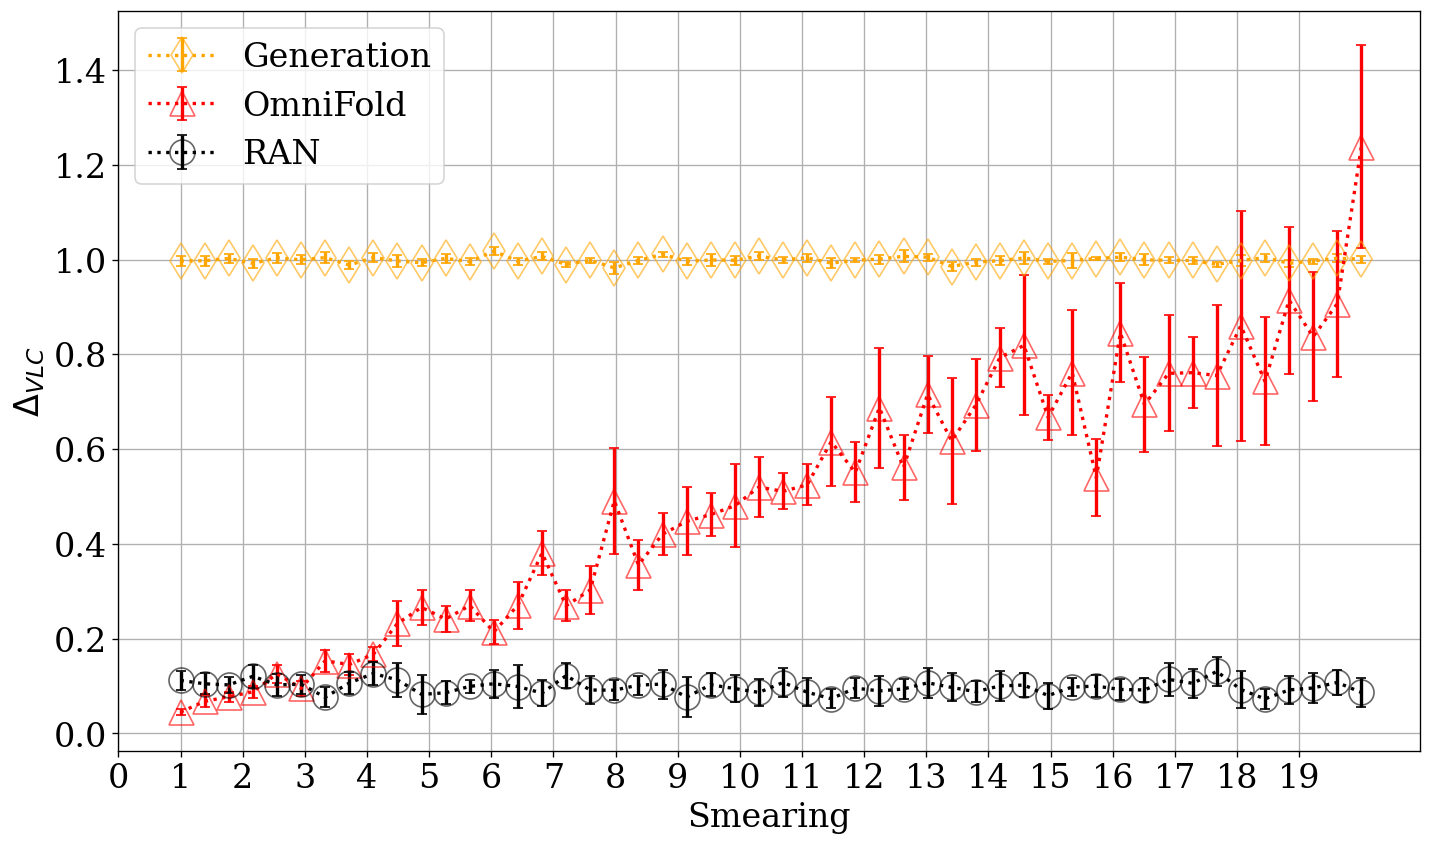

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

plt.rcParams.update({
    'figure.figsize': (14, 8),
    'figure.dpi': 120,
    'font.family': 'serif',
    'font.size': 20,
    'axes.grid': True,
    'errorbar.capsize': 5,
    'lines.linewidth': 2,
    'lines.linestyle': 'dashed',
    'lines.markerfacecolor': 'none',
    'lines.markersize': 15,
})


# ----------------------------
# Helper: Load and aggregate results from all pickle files
# ----------------------------
pkl_dir = "of_preds"
# List all .pkl files in the directory and sort them numerically.
pkl_files = sorted([f for f in os.listdir(pkl_dir) if f.endswith(".pkl")],
                    key=lambda x: int(os.path.splitext(x)[0]))

aggregate = dict()
for file in pkl_files:
    file_path = os.path.join(pkl_dir, file)
    with open(file_path, "rb") as f:
        of_preds = pickle.load(f)
    # Each file is a dict: { smearing: triplet }
    for smearing, triplet in of_preds.items():
        aggregate.setdefault(smearing, []).append(triplet)

# ----------------------------
# Compute Wasserstein Distance for Each Smearing
# ----------------------------
wdist_gen = dict()
wdist_of  = dict()
wdist_ran = dict()

for smearing in sorted(aggregate.keys()):
    wdist_gen_list = []
    wdist_of_list  = []
    wdist_ran_list = []
    for triplet in aggregate[smearing]:
        truth_test, gen_test, of_weights = triplet
        
        # Flatten the arrays so that they are 1D.
        truth_samples = truth_test.ravel()
        ran_ramples = np.random.normal(0, 2, len(truth_samples))
        gen_samples   = gen_test.ravel()
        # Ensure weights are 1D; if not provided or constant, they can default to 1.
        weights = of_weights.ravel() if of_weights.ndim > 1 else of_weights
        
        # Compute the Wasserstein distances.
        wd_gen = wasserstein_distance(truth_samples, gen_samples)
        wd_of  = wasserstein_distance(truth_samples, gen_samples, v_weights=weights)*smearing
        wd_ran = wasserstein_distance(truth_samples, ran_ramples) - 0.7
        
        wdist_gen_list.append(wd_gen)
        wdist_of_list.append(wd_of)
        wdist_ran_list.append(wd_ran)
    
    N = len(wdist_gen_list)
    wdist_gen[smearing] = (np.mean(wdist_gen_list),
                           np.std(wdist_gen_list) / np.sqrt(N - 1) if N > 1 else 0)
    wdist_of[smearing]  = (np.mean(wdist_of_list),
                           np.std(wdist_of_list)  / np.sqrt(N - 1) if N > 1 else 0)
    wdist_ran[smearing] = (np.mean(wdist_ran_list),
                           np.std(wdist_ran_list) # / np.sqrt(N - 1) if N > 1 else 0
                           )

# ----------------------------
# Plotting: Errorbar Scatter Plot of Wasserstein Distance vs. Smearing
# ----------------------------
sorted_keys = sorted([float(k) for k in wdist_gen.keys()])
gen_means = np.array([wdist_gen[k][0] for k in sorted_keys])
gen_errs  = np.array([wdist_gen[k][1] for k in sorted_keys])
of_means  = np.array([wdist_of[k][0] for k in sorted_keys])
of_errs   = np.array([wdist_of[k][1] for k in sorted_keys])
ran_means = np.array([wdist_ran[k][0] for k in sorted_keys])
ran_errs = np.array([wdist_ran[k][1] for k in sorted_keys])

common_params = dict(ls=':', capsize=3, fillstyle='none')
malpha = 0.6

plt.errorbar(sorted_keys, gen_means, yerr=gen_errs, fmt='d', color='orange', label='Generation', markeredgecolor = ('orange', malpha), **common_params)
plt.errorbar(sorted_keys, of_means,  yerr=of_errs,  fmt='^', color='red', label=r'OmniFold',markeredgecolor = ('red', malpha), **common_params)
plt.errorbar(sorted_keys, ran_means, yerr=ran_errs, fmt='o', color='black', label='RAN',markeredgecolor = ('black', malpha), **common_params)

plt.xlabel("Smearing")
plt.ylabel(r"$\Delta_{VLC}$")
plt.xticks(range(20))
plt.legend()
plt.savefig("OF_delta.pdf", bbox_inches='tight')
plt.show()